### MTH 9875 The Volatility Surface:    Fall 2015 

<p>

### Lecture 4: Efficient simulation of the Heston model

Jim Gatheral   
Department of Mathematics   
  

  
  
<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/BaruchLogo2.png" align = "left" width=160></h3>  


<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/07/MFElogo.png" align = "right" width=100></h3>
   

###Outline of lecture 4

* Heston variance simulation with full truncation


* The Ninomiya-Victoir scheme
    
    * Alfonsi's variance discretization
    * Full NV Heston discretization


* Variance reduction techniques


* Applications

    * The volatility smile
    * Local variance
    * The volatility surface

### First download some code

In [1]:
download.file(url="http://mfe.baruch.cuny.edu/wp-content/uploads/2015/09/9875-4.zip", destfile="9875-4.zip")
unzip(zipfile="9875-4.zip")
source("BlackScholes.R")
source("Heston.R")

### Heston parameters

In [2]:
paramsBCC <- list(lambda = 1.15,rho = -0.64,eta = 0.39,vbar = 0.04,v = 0.04) 
paramsBCC1 <- list(lambda = 1.15,rho = -0.64,eta = .39/2,vbar = 0.04,v = 0.04) 
paramsBCC2 <- list(lambda = 1.15,rho = -0.64,eta = 0.39*2,vbar = 0.04,v = 0.04) 

Recall from Lecture 3 that with both BCC and BCC2 parameters, zero is attainable.

###Exact Heston implied volatility computations

To compute the bias of a simulation scheme, we need to know exact implied volatilities.

In [3]:
strikes <- c(0.8,1.0,1.2) 
print(exactHestonVolsBCC <- sapply(strikes,function(K){impvolHeston(paramsBCC)(log(K),1)}) )
print(exactHestonVolsBCC1 <- sapply(strikes,function(K){impvolHeston(paramsBCC1)(log(K),1)}) )
print(exactHestonVolsBCC2 <- sapply(strikes,function(K){impvolHeston(paramsBCC2)(log(K),1)}) )


[1] 0.2289957 0.1817281 0.1520478
[1] 0.2184855 0.1940710 0.1748623
[1] 0.2320480 0.1532666 0.1334544


Note how the skew increases as we increase $\eta$!

###Code for Euler with  partial truncation

Recall that this discretization reads:

$$
v_{t+\Delta}=v_t - \lambda\,\left(v_t-\bar v\right)\,\Delta+\eta\,\sqrt{v_t^+}\,\sqrt{\Delta}\,Z.
$$

In [4]:
evolveEulerP <- function(v,x,dt,Z,W,i){

        #Variance process
        v2 <- (v > 0) * v  # Take v2 = 0 if v<0, else v2=v
        vf <- v - lambda*(v-vbar)*dt +eta * sqrt(v2)*sqrt(dt)*W 

        # Log-stock process
        x <- x  - (v+vf)/4*dt + sqrt(v2*dt) * Z
        # Impose martingale constraint
        x <- x - log(mean(exp(x))) 
        v <- vf 
        
        return(cbind(x,v)) 
}

###Code for Euler with  full truncation

Recall that this discretization reads:

$$
v_{t+\Delta}=v_t - \lambda\,\left(v_t^+-\bar v\right)\,\Delta+\eta\,\sqrt{v_t^+}\,\sqrt{\Delta}\,Z.
$$

In [5]:
evolveEulerF <- function(v,x,dt,Z,W,i){

        #Variance process
        v2 <- (v > 0) * v  # Take v2 = 0 if v<0, else v2=v
        vf <- v - lambda*(v2-vbar)*dt +eta * sqrt(v2)*sqrt(dt)*W 

        # Log-stock process
        x <- x  - (v+vf)/4*dt + sqrt(v2*dt) * Z
        # Impose martingale constraint
        x <- x - log(mean(exp(x))) 
        v <- vf 
        
        return(cbind(x,v)) 
}

###Heston code that uses the above time discretization

Note that the code also does Richardson extrapolation.

In [6]:
is.even <- function(j){as.logical((j+1) %% 2)} # A little function needed later

HestonMC <- function(params){
    
    res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
    {
  
    lambda <<- params$lambda 
    rho <<- params$rho 
    eta <<- params$eta 
    vbar <<- params$vbar 
    v0 <<- params$v 
    
   	phi <<- sqrt(1-rho^2) 
  
    n <- m*2  #n is number of timesteps = 2*m so we can use Richardson extrapolation
    sqrt2 <- sqrt(2) 
    rho2m1 <- sqrt(1-rho*rho) 
    
    negCount <- 0 
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); v <- rep(1,N)*v0 
    xm <- x; vm <- v 
    W1m <- rep(0,N); W2m <- rep(0,N)  
  
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
        # Two sets of correlated normal random vars.
        
        W1 <- rnorm(N) 
        W2 <- rnorm(N) 
        W1 <- W1 - mean(W1);  W1 <- W1/sd(W1) 
        W2 <- W2 - mean(W2);  W2 <- W2/sd(W2) 
        # Now W1 and W2 are forced to have mean=0 and sd=1
        
        W2p <- W2 - cor(W1,W2)*W1  # Eliminate actual correlation
        W2p <- W2p - mean(W2p);  W2 <- W2p/sd(W2p) 
        W2 <- rho*W1 + rho2m1*W2  
        # Now W1 and W2 have mean=0, sd=1 and correlation rho
    
        # Add code for subgrid
        W1m <- W1m + W1/sqrt2;  W2m <- W2m + W2/sqrt2  # N(0,1) rv's for subgrid
       
        if (is.even(i)) {
            #print(c(i,mean(W1m),mean(W2m),sd(W1m),sd(W2m),cor(W1m,W2m))) 
            resm <- evolve(vm,xm,T/m,W1m,W2m,i/2) 
            xm <- resm[,1] 
            vm <- resm[,2] 
            W1m <- rep(0,N);  W2m <- rep(0,N) 
        }
    
        res <- evolve(v,x,T/n,W1,W2,i) 
        x <- res[,1] 
        v <- res[,2] 
        negCount <- negCount +mean(v<0)/n  #Probability of negative variance per path per timestep
    
  }

    S <- S0*exp(x) 
    Sm <- S0*exp(xm) 

    # Now we have three vectors of final stock prices
  
    M <- length(AK) 
    AV <- numeric(M); AVdev <- numeric(M) 
    BSV <- numeric(M); BSVH <- numeric(M);  BSVL <- numeric(M) 
    iv2SD <- numeric(M);  bias <- numeric(M) 
    AVm <- numeric(M);  AVmdev <- numeric(M) 
    BSVm <- numeric(M);  BSVHm <- numeric(M);  BSVLm <- numeric(M) 
    iv2SDm <- numeric(M) 
    AV1 <- numeric(M);  AV1dev <- numeric(M) 
    BSV1 <- numeric(M); BSVH1 <- numeric(M); BSVL1 <- numeric(M) 
    iv2SDrom <- numeric(M); biasRom <- numeric(M) 
  
  # Evaluate mean call value for each path
  for (i in 1:M)
  {
    # 2*m timesteps
    K <- AK[i] 
    V <- (S>K)*(S - K)  # Boundary condition for European call
    AV[i] <- mean(V) 
    AVdev[i] <- sqrt(var(V)/length(V)) 
    
    BSV[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i]) 
    BSVL[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] - AVdev[i]) 
    BSVH[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] + AVdev[i]) 
    iv2SD[i] <- (BSVH[i]-BSVL[i]) 
    
    # m timesteps
    Vm <- (Sm>K)*(Sm - K)  # Boundary condition for European call
    AVm[i] <- mean(Vm) 
    AVmdev[i] <- sd(Vm) / sqrt(N) 
    BSVm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i]) 
    BSVLm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] - AVmdev[i]) 
    BSVHm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] + AVmdev[i]) 
    iv2SDm[i] <- (BSVH[i]-BSVL[i]) 
    
    # Romberg estimates 
    V1 <- 2*V - Vm 
    AV1[i] <- mean(V1) 
    AV1dev[i] <- sd(V1) / sqrt(N) 
    BSV1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i]) 
    BSVL1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] - AV1dev[i]) 
    BSVH1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] + AV1dev[i]) 
    iv2SDrom[i] <- (BSVH1[i]-BSVL1[i]) 
    
    if(!is.null(exactVols)) {bias <- BSV-exactVols} 
    if(!is.null(exactVols)) {biasRom <- BSV1-exactVols} 
  }
  
  l.AK <- length(AK)      
  data.out <- data.frame(AK,rep(N,l.AK),rep(2*m,l.AK),BSV,bias,iv2SD,BSVm,BSV1,biasRom,iv2SDrom) 
  names(data.out) <- c("Strikes","Paths","Steps","ivol","bias","twoSd","ivolm", "ivolRichardson", "biasRichardson","twoSdRichardson") 
  return(data.out) 
  
  
}
return(res) 
}

Here's an example of a function call:

In [7]:
HestonMC(paramsBCC)(S0=1, T=1, strikes, N=100000, m=4, evolve=evolveEulerF, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol        bias       twoSd     ivolm
1     0.8 1e+05     8 0.2310575 0.002061791 0.004443198 0.2337710
2     1.0 1e+05     8 0.1855852 0.003857069 0.001606880 0.1931710
3     1.2 1e+05     8 0.1564881 0.004440381 0.001159100 0.1667388
  ivolRichardson biasRichardson twoSdRichardson
1      0.2283144   -0.000681290     0.005044522
2      0.1780021   -0.003726078     0.001902873
3      0.1452307   -0.006817066     0.001614098

###Convergence with BCC parameters

In [8]:
load("mc.convergence.rData")

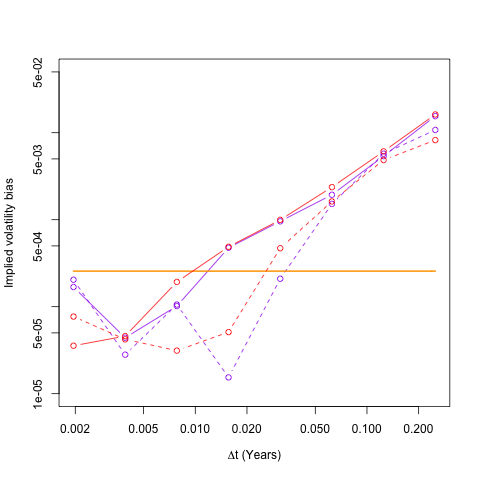

In [9]:
tmp <- resF.BCC
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="purple",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="purple",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resP.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="red",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="red",lty=2)

Figure 1: One year option, $K=1.2$ with BCC parameters.  Euler with partial truncation in red; full truncation in purple; dashed lines are from Richardson extrapolation.

* The difference between partial and full truncation seems to be minimal; full truncation wins by a hair.

###Convergence with BCC2 parameters

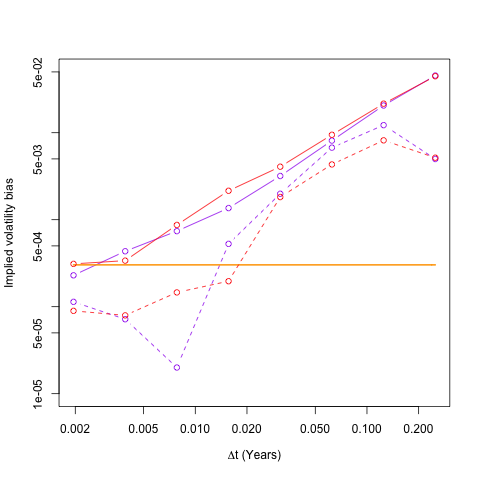

In [10]:
tmp <- resF.BCC2
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="purple",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="purple",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resP.BCC2
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="red",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="red",lty=2)

Figure 2: One year option, $K=1.2$ with BCC2 parameters.  Euler with partial truncation in red; full truncation in purple; dashed lines are from Richardson extrapolation.

* Again, full truncation wins by a hair.

### Formal solution of the Heston SDE

$$
\newcommand{\E}{\mathbb{E}}
$$

We write the Heston SDE in the form

\begin{eqnarray*}
d(\log S)&=&-\frac{v}{2}\,dt+\sqrt{v}\,\left\{\rho\,dW_t+\sqrt{1-\rho^2}\,dW_t^\perp\right\}\\
dv&=&-\lambda(v-\bar v)\,dt+\eta\,\sqrt{v}\,dW_t
\end{eqnarray*}

The exact solution may then be written as

<a name="eq:BroadieKaya"></a>(1)
$$
\begin{eqnarray*}
S_t&=&S_0\,\exp\left\{-\frac{1}{2}\,\int_0^t\,v_s\,ds+\rho\,\int_0^t\,\sqrt{v_s}\,dW_s+\sqrt{1-\rho^2}\,\int_0^t\sqrt{v_s}\,dW_s^\perp\,\right\}\nonumber\\
v_t&=&v_0+\lambda\,\bar v \,t
-\lambda\,\int_0^t\,v_s\,ds+\eta\,\int_0^t\,\sqrt{v_s}\,dW_s
\end{eqnarray*}
$$

with
$
\E[dW_s \,{dW_s^\perp}] =0
$.

###Andersen's simulation procedure

* [Andersen]<sup id="cite_ref-Andersen" class="reference"><a href="#cite_note-Andersen"><span>[</span>2<span>]</span></a></sup> proposes to simulate processes like the square-root variance process by sampling from a distribution that is similar to the true distribution but not the same.

    * This approximate distribution should have at least the same mean and variance as the true distribution.
    * More generally, this distribution should have a similar shape.

* Applying his approach to simulating the Heston process, we would have to at least find the means and variances of $\int_0^t\,\sqrt{v_s}\,dW_s$, $\int_0^t \,v_s\, ds$, $v_t$ and $v_0$.

    * This can only be done when the mean and variance are computable.
    * These moments are computable in the case of the Heston model.


* Again, we want to focus on generic techniques.

###Cross terms

* We have discretized the stock and variance parts of the Heston SDE to $\mathcal{O}(\Delta)$ separately.

    * In principle, we pick up higher order cross terms too.
    * However, the conditions for higher order schemes such as Milstein are not met in the Heston model so some say there is little advantage in getting more complicated.

* Andersen disagrees.

    * So far, we have discretized $x=\log S$ as 
<br><br><a name="eq:31"></a>(2)
$$
x_{t+\Delta}=x_t-\frac12\,(v_t+v_{t+\Delta})\,\Delta +\sqrt{v_t}\,\sqrt{\Delta}\,Z
$$
with $\E[W \,Z]=\rho$.

    * He observes that if there is a significant probability of a negative $v$, the actual correlation between $\Delta v$ and $\Delta x$ will not be $\rho$ because $v$ has been truncated.

###Leaking correlation



Quote from [Andersen]<sup id="cite_ref-Andersen" class="reference"><a href="#cite_note-Andersen"><span>[</span>2<span>]</span></a></sup>
>If one were to "insist on using [(2)](#eq:31), at practical levels of $\Delta$, one would experience a strong tendency for the Monte Carlo simulation to generate too feeble effective correlation and, consequently, paths of $x$ with poor distribution tails.  In call option pricing terms, this would manifest itself in an overall poor ability to price options with strikes away from at-the-money."

###Andersen's solution

Noting that

$$
\eta\,\sqrt{v_t}\,\sqrt{\Delta} \,W = v_{t+\Delta}-v_t+\lambda\,(v_t-\bar v)\,\Delta,
$$

and motivated by the exact formal expression [(1)](#eq:BroadieKaya), Andersen suggests the following $x$-discretization instead:

<a name="eq:33"></a>(3)
\begin{eqnarray}
x_{t+\Delta}&=&x_t+\left(\frac{\rho}{\eta}-\frac12\right)\,(v_t+v_{t+\Delta})\,\Delta
+\frac{\rho}{\eta}\,\left(v_{t+\Delta}-v_t+\lambda\,(v_t-\bar v)\,\Delta \right)\nonumber\\
&&\quad\quad\quad+\sqrt{1-\rho^2}\,\sqrt{\frac12(v_t+v_{t+\Delta})}\,\sqrt{\Delta}\,W^\perp
\end{eqnarray}

where $W^\perp$ is orthogonal to $W$ (from the variance process).

* Let's check to see if [(3)](#eq:33) really does better than [(2)](#eq:31)!

###Code for Andersen discretization

First the `EulerF` timestep with Andersen $x$-discretization:

In [11]:
evolveEulerFAndersen <- function(v,x,dt,Z,W,i){
        
        #Variance process
        v2 <- (v > 0) * v  # Take v2 = 0 if v<0, else v2=v
        vf <-  v - lambda*(v2 - vbar)*dt +eta * sqrt(v2)*sqrt(dt)*W 
                               
        # Log-stock process (Andersen equation (33))
        vvf <- (v+vf > 0) * (v+vf) 
        dw <- vvf/2*dt 
        x <- x  - dw/2 + rho2m1*sqrt(dw)*Z +
            rho/eta*(lambda*dw + vf-v -lambda*vbar*dt)  
        # Impose martingale constraint
        x <- x - log(mean(exp(x))) 
        v <- vf 
        return(cbind(x,v)) 
}

This new x-discretizations needs a new Monte Carlo routine:

In [12]:
HestonMCAndersen <- function(params){
    
    res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
    {
  
    lambda <<- params$lambda 
    rho <<- params$rho 
    eta <<- params$eta 
    vbar <<- params$vbar 
    v0 <<- params$v 
  
    n <- m*2  #n is number of timesteps = 2*m so we can use Romberg extrapolation
    sqrt2 <- sqrt(2) 
    rho2m1 <<- sqrt(1-rho*rho) 
    
    negCount <- 0 
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N);  v <- rep(1,N)*v0 
    xm <- x;  vm <- v 
    W1m <- rep(0,N);  W2m <- rep(0,N)  
  
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
        # Two sets of correlated normal random vars.
        
        W1 <- rnorm(N) 
        W2 <- rnorm(N) 
        W1 <- W1 - mean(W1);  W1 <- W1/sd(W1) 
        W2 <- W2 - mean(W2);  W2 <- W2/sd(W2) 
        # Now W1 and W2 are forced to have mean=0 and sd=1
        
        W2p <- W2 - cor(W1,W2)*W1  # Eliminate actual correlation
        W2p <- W2p - mean(W2p);  W2 <- W2p/sd(W2p)  
        # Now W1 and W2 have mean=0, sd=1 and correlation=0
    
        # Add code for subgrid
        W1m <- W1m + W1/sqrt2;  W2m <- W2m + W2/sqrt2  # N(0,1) rv's for subgrid
       
        if (is.even(i)) {
            resm <- evolve(vm,xm,T/m,W1m,W2m,i/2) 
            xm <- resm[,1] 
            vm <- resm[,2] 
            W1m <- rep(0,N);  W2m <- rep(0,N) 
        }
    
        res <- evolve(v,x,T/n,W1,W2,i) 
        x <- res[,1] 
        v <- res[,2] 
        negCount <- negCount +mean(v<0)/n  #Probability of negative variance per path per timestep
    
  }

    S <- S0*exp(x) 
    Sm <- S0*exp(xm) 

    # Now we have three vectors of final stock prices
  
    M <- length(AK) 
    AV <- numeric(M);  AVdev <- numeric(M) 
    BSV <- numeric(M) ; BSVH <- numeric(M);  BSVL <- numeric(M) 
    iv2SD <- numeric(M);  bias <- numeric(M) 
    AVm <- numeric(M);  AVmdev <- numeric(M) 
    BSVm <- numeric(M);  BSVHm <- numeric(M);  BSVLm <- numeric(M) 
    iv2SDm <- numeric(M) 
    AV1 <- numeric(M);  AV1dev <- numeric(M) 
    BSV1 <- numeric(M);  BSVH1 <- numeric(M);  BSVL1 <- numeric(M) 
    iv2SDrom <- numeric(M); biasRom <- numeric(M) 
  
  # Evaluate mean call value for each path
  for (i in 1:M)
  {
    # 2*m timesteps
    K <- AK[i] 
    V <- (S>K)*(S - K)  # Boundary condition for European call
    AV[i] <- mean(V) 
    AVdev[i] <- sqrt(var(V)/length(V))
    
    BSV[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i]) 
    BSVL[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] - AVdev[i]) 
    BSVH[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] + AVdev[i]) 
    iv2SD[i] <- (BSVH[i]-BSVL[i]) 
    
    # m timesteps
    Vm <- (Sm>K)*(Sm - K)  # Boundary condition for European call
    AVm[i] <- mean(Vm) 
    AVmdev[i] <- sd(Vm) / sqrt(N) 
    BSVm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i]) 
    BSVLm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] - AVmdev[i]) 
    BSVHm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] + AVmdev[i]) 
    iv2SDm[i] <- (BSVH[i]-BSVL[i]) 
    
    # Romberg estimates 
    V1 <- 2*V - Vm 
    AV1[i] <- mean(V1) 
    AV1dev[i] <- sd(V1) / sqrt(N) 
    BSV1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i]) 
    BSVL1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] - AV1dev[i]) 
    BSVH1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] + AV1dev[i]) 
    iv2SDrom[i] <- (BSVH1[i]-BSVL1[i]) 
    
    if(!is.null(exactVols)) {bias <- BSV-exactVols} 
    if(!is.null(exactVols)) {biasRom <- BSV1-exactVols} 
  }
  
  l.AK <- length(AK)      
  data.out <- data.frame(AK,rep(N,l.AK),rep(2*m,l.AK),BSV,bias,iv2SD,BSVm,BSV1,biasRom,iv2SDrom) 
  names(data.out) <- c("Strikes","Paths","Steps","ivol","bias","twoSd","ivolm", "ivolRichardson", "biasRichardson","twoSdRichardson") 
  return(data.out) 
  
}
return(res) 
}

### Example of function call

In [13]:
HestonMCAndersen(paramsBCC)(S0=1, T=1, strikes, N=100000, m=16, evolve=evolveEulerFAndersen, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol          bias       twoSd     ivolm
1     0.8 1e+05    32 0.2304248  1.429107e-03 0.004372534 0.2322376
2     1.0 1e+05    32 0.1826494  9.212416e-04 0.001563084 0.1838195
3     1.2 1e+05    32 0.1520328 -1.491615e-05 0.001139029 0.1521258
  ivolRichardson biasRichardson twoSdRichardson
1      0.2285988  -0.0003969365     0.004584510
2      0.1814793  -0.0002488027     0.001653490
3      0.1519398  -0.0001079627     0.001215423

###Convergence with BCC parameters

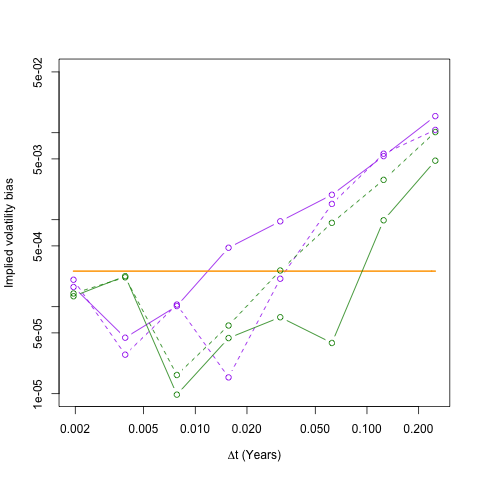

In [14]:
tmp <- resF.BCC
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="purple",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="purple",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resFAndersen.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)

Figure 3: One year option, $K=1.2$ with BCC parameters.  Euler with full truncation in purple;  with Andersen $x$-discretization in green; dashed lines are from Richardson extrapolation.

* Andersen's $x$ discretization seems to do much better!

###Convergence with BCC2 parameters


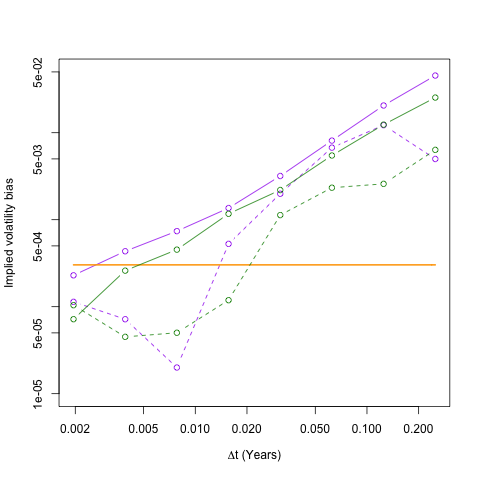

In [15]:
tmp <- resF.BCC2
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="purple",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="purple",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resFAndersen.BCC2
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)

Figure 4: Euler with full truncation in purple; with Andersen $x$-discretization in green; dashed lines are with Richardson extrapolation ($K=1.2$; $T=1$)

* Andersen's discretization is better, and Richardson extrapolation improves it.

###The Alfonsi Heston scheme

[Alfonsi (2010)]<sup id="cite_ref-Alfonsi:2010" class="reference"><a href="#cite_note-Alfonsi:2010"><span>[</span>1<span>]</span></a></sup> implements the following scheme for variance:

<a name="eq:Alfonsi2010"></a>(4)
\begin{eqnarray}
 v_{t+\Delta}&=&e^{-\lambda\,\Delta/2}\,\left(\sqrt{v_t\,e^{-\lambda\,\Delta/2}+\left[\lambda \,\bar v-\frac{\eta^2}{4}\right]\,\psi\left(\frac{\Delta}{2}\right)}
+\frac{\eta}{2}\,\sqrt{\Delta}\,Z
\right)^2\nonumber\\
&&\quad\quad\quad+\left[\lambda \,\bar v-\frac{\eta^2}{4}\right]\,\psi\left(\frac{\Delta}{2}\right)
\end{eqnarray}
with $Z \sim N(0,1)$ and as before,

$$
\psi(x):=\frac{1-e^{-\lambda x}}{\lambda}
$$

Note in particular that $v_{t+\Delta}>0$ if $4\,\lambda\,\bar v > \eta^2$.  So the discretized variance process cannot hit zero with BCC or BCC1 parameters.

###Alfonsi (2010) code

In [16]:
evolveAlfonsi <- function(v,x,dt,W1,W2,L=NULL){

        eldt2 <- exp(-lambda*dt/2);

        #Variance process
        vbarp <- vbar - eta^2/(4*lambda);
        psi <- (1-eldt2)/lambda;
        v1 <- v*eldt2 + lambda*vbarp*psi;
        v2 <- (v1 > 0) * v1; # Take v2 = 0 if v1<0, else v2=v1
        par <- sqrt(v2) + eta/2*sqrt(dt)*W2;
        vf <- eldt2*par*par + lambda*vbarp*psi;

        # Log-stock process (Andersen equation (33))
        vvf <- (v+vf > 0) * (v+vf);
        dw <- vvf/2*dt;
        x <- x  - dw/2 + rho2m1*sqrt(dw)*W1 +
            rho/eta*(lambda*dw + vf-v -lambda*vbar*dt) ;
        # Impose martingale constraint
        x <- x - log(mean(exp(x)));
        v <- vf;
        return(cbind(x,v));
}

Here's Monte Carlo code that uses the above time step:

In [17]:
HestonMC2 <- function(params){
    
    is.even <- function(j){as.logical((j+1) %% 2)}
    
    res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
    {
  
    lambda <<- params$lambda;
    rho <<- params$rho;
    eta <<- params$eta;
    vbar <<- params$vbar;
    v0 <<- params$v;
  
    n <- m*2; #n is number of timesteps = 2*m so we can use Romberg extrapolation
    sqrt2 <- sqrt(2);
    rho2m1 <<- sqrt(1-rho*rho);
    vbarp <<- vbar - eta^2/(4*lambda);
    
    negCount <- 0;
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); v <- rep(1,N)*v0;
    xm <- x; vm <- v;
    W1m <- rep(0,N); W2m <- rep(0,N); 
  
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
        # Two sets of correlated normal random vars.
        
        W1 <- rnorm(N);
        W2 <- rnorm(N);
        W1 <- W1 - mean(W1); W1 <- W1/sd(W1);
        W2 <- W2 - mean(W2); W2 <- W2/sd(W2);
        # Now W1 and W2 are forced to have mean=0 and sd=1
        
        W2p <- W2 - cor(W1,W2)*W1; # Eliminate actual correlation
        W2p <- W2p - mean(W2p); W2 <- W2p/sd(W2p); 
        # Now W1 and W2 have mean=0, sd=1 and correlation=0
        
        L <- rbinom(N, size=1, prob=1/2); # Bernoulli rv for NV step
    
        # Add code for subgrid
        W1m <- W1m + W1/sqrt2; W2m <- W2m + W2/sqrt2; # N(0,1) rv's for subgrid
       
        if (is.even(i)) {
            #print(c(i,mean(W1m),mean(W2m),sd(W1m),sd(W2m),cor(W1m,W2m)));
            resm <- evolve(vm,xm,T/m,W1m,W2m,L);
            xm <- resm[,1];
            vm <- resm[,2];
            W1m <- rep(0,N); W2m <- rep(0,N);
        }
    
        res <- evolve(v,x,T/n,W1,W2,L);
        x <- res[,1];
        v <- res[,2];
        negCount <- negCount +mean(v<0)/n; #Probability of negative variance per path per timestep
    
  }

    S <- S0*exp(x);
    Sm <- S0*exp(xm);

    # Now we have three vectors of final stock prices
  
    M <- length(AK);
    AV <- numeric(M); AVdev <- numeric(M);
    BSV <- numeric(M); BSVH <- numeric(M); BSVL <- numeric(M);
    iv2SD <- numeric(M); bias <- numeric(M);
    AVm <- numeric(M); AVmdev <- numeric(M);
    BSVm <- numeric(M); BSVHm <- numeric(M); BSVLm <- numeric(M);
    iv2SDm <- numeric(M);
    AV1 <- numeric(M); AV1dev <- numeric(M);
    BSV1 <- numeric(M); BSVH1 <- numeric(M); BSVL1 <- numeric(M);
    iv2SDrom <- numeric(M);biasRom <- numeric(M);
  
  # Evaluate mean call value for each path
  for (i in 1:M)
  {
    # 2*m timesteps
    K <- AK[i];
    V <- (S>K)*(S - K); # Boundary condition for European call
    AV[i] <- mean(V);
    AVdev[i] <- sqrt(var(V)/length(V));  
    
    BSV[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i]);
    BSVL[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] - AVdev[i]);
    BSVH[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] + AVdev[i]);
    iv2SD[i] <- (BSVH[i]-BSVL[i]);
    
    # m timesteps
    Vm <- (Sm>K)*(Sm - K); # Boundary condition for European call
    AVm[i] <- mean(Vm);
    AVmdev[i] <- sd(Vm) / sqrt(N);
    BSVm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i]);
    BSVLm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] - AVmdev[i]);
    BSVHm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] + AVmdev[i]);
    iv2SDm[i] <- (BSVH[i]-BSVL[i]);
    
    # Richardson extrapolation estimates 
    V1 <- 2*V - Vm;
    AV1[i] <- mean(V1);
    AV1dev[i] <- sd(V1) / sqrt(N);
    BSV1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i]);
    BSVL1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] - AV1dev[i]);
    BSVH1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] + AV1dev[i]);
    iv2SDrom[i] <- (BSVH1[i]-BSVL1[i]);
    
    if(!is.null(exactVols)) {bias <- BSV-exactVols};
    if(!is.null(exactVols)) {biasRom <- BSV1-exactVols};
  }
  
  
  l.AK <- length(AK)      
  data.out <- data.frame(AK,rep(N,l.AK),rep(2*m,l.AK),BSV,bias,iv2SD,BSVm,BSV1,biasRom,iv2SDrom) 
  names(data.out) <- c("Strikes","Paths","Steps","ivol","bias","twoSd","ivolm", "ivolRichardson", "biasRichardson","twoSdRichardson") 
  return(data.out) 
  
  
}
return(res)
}

Here's an example of how to call the code:

In [18]:
HestonMC2(paramsBCC)(S0=1, T=1, AK=strikes, N=100000, m=4, evolve=evolveAlfonsi, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol         bias       twoSd     ivolm
1     0.8 1e+05     8 0.2290701 7.433206e-05 0.004393698 0.2286915
2     1.0 1e+05     8 0.1818473 1.191834e-04 0.001567430 0.1815342
3     1.2 1e+05     8 0.1528003 7.525073e-04 0.001132833 0.1531273
  ivolRichardson biasRichardson twoSdRichardson
1      0.2294481   0.0004523493     0.004521863
2      0.1821605   0.0004323231     0.001638616
3      0.1524722   0.0004244599     0.001219249

### Convergence of the Alfonsi scheme with BCC parameters

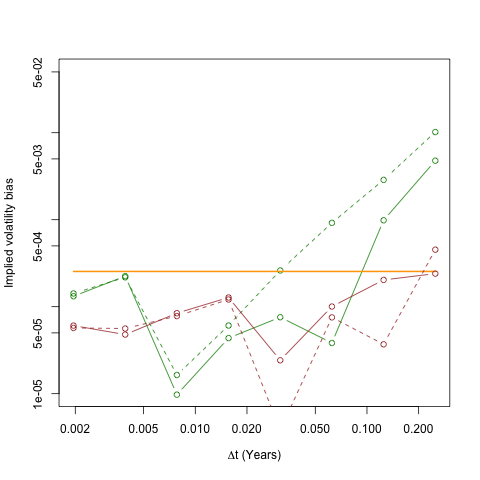

In [19]:
tmp <- resFAndersen.BCC
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resAlfonsi.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="brown",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="brown",lty=2)

Figure 5: Euler with full truncation and Andersen $x$-discretization in green; Alfonsi in brown; dashed lines are with Richardson extrapolation ($T=1$, $K=1.2$)

###Convergence of the Alfonsi scheme with BCC2 parameters

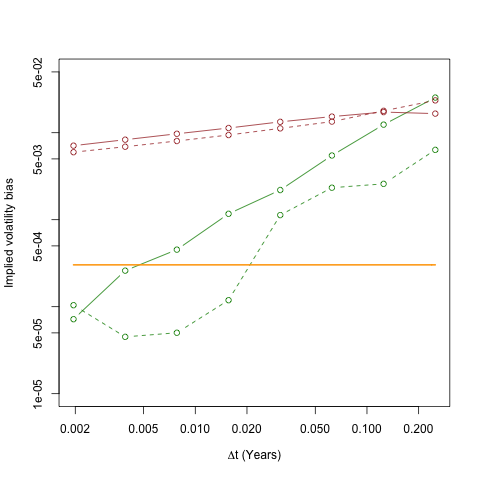

In [20]:
tmp <- resFAndersen.BCC2
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resAlfonsi.BCC2
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="brown",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="brown",lty=2)

Figure 6: Euler with full truncation and Andersen $x$-discretization in green; Alfonsi in brown; dashed lines are with Richardson extrapolation ($T=1$, $K=1.2$)

* Now Alfonsi is underperforming.

###Alfonsi code with full truncation

In [21]:
evolveAlfonsiF <- function(v,x,dt,W1,W2,L=NULL){

        eldt2 <- exp(-lambda*dt/2);

        #Variance process
        vbarp <- vbar - eta^2/(4*lambda);
        psi <- (1-eldt2)/lambda;
        v1 <- v*eldt2+lambda*vbarp*psi;
        v2 <- (v1 > 0) * v1; # Take v2 = 0 if v1<0, else v2=v1
        par <- sqrt(v2) + eta/2 * sqrt(dt)*W2;
        vf <- eldt2*par*par +lambda*vbarp*psi + v1 - v2;
                                # Full truncation

        # Log-stock process (Andersen equation (33))
        vvf <- (v+vf > 0) * (v+vf);
        dw <- vvf/2*dt;
        x <- x  - dw/2 + rho2m1*sqrt(dw)*W1 +
            rho/eta*(lambda*dw + vf-v -lambda*vbar*dt) ;
        # Impose martingale constraint
        x <- x - log(mean(exp(x)));
        v <- vf;
        return(cbind(x,v));
}

Once again, here's how to run the code:

In [22]:
HestonMC2(paramsBCC)(S0=1, T=1, AK=strikes, N=100000, m=4, evolve=evolveAlfonsiF, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol          bias       twoSd     ivolm
1     0.8 1e+05     8 0.2287799 -0.0002158135 0.004389728 0.2283266
2     1.0 1e+05     8 0.1813934 -0.0003347400 0.001561587 0.1811047
3     1.2 1e+05     8 0.1522542  0.0002064202 0.001122176 0.1524356
  ivolRichardson biasRichardson twoSdRichardson
1      0.2292324   2.366572e-04     0.004519027
2      0.1816821  -4.603280e-05     0.001634922
3      0.1520724   2.466899e-05     0.001208573

###Convergence of Alfonsi scheme with full truncation and BCC2 parameters


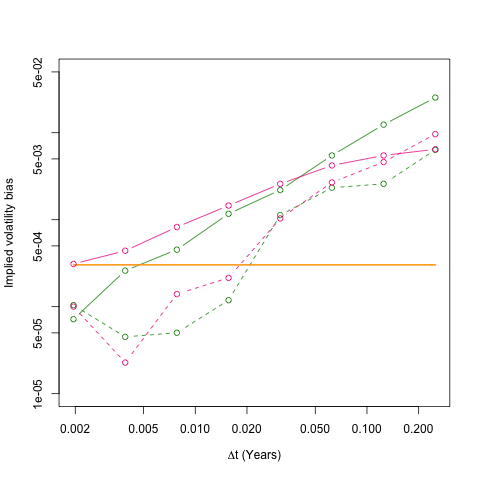

In [23]:
tmp <- resFAndersen.BCC2
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resAlfonsiF.BCC2
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="deeppink2",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="deeppink2",lty=2)

Figure 7: Euler with full truncation and Andersen $x$-discretization in green; Alfonsi with full truncation in pink; dashed lines are with Richardson extrapolation ($T=1$, $K=1.2$)

* Now the problem with Alfonsi is fixed!

###Convergence of moments

$$
\newcommand{\Var}{\mathop{Var}}
$$

Recall from Lecture 3 that in the Heston model,

$$
\hat v_{t+\Delta}:=\mathbb{E}\left[v_{t+\Delta}|v_t\right]=\bar v+(v_t-\bar v)\,e^{-\lambda\,\Delta}
$$

and

$$
\begin{eqnarray}
\Var\left[v_{t+\Delta}|v_t\right]&=&\int_t^{t+\Delta}\,e^{-2\,\lambda\,(T-t)}\,\eta^2\,\hat v_s\,dt\\
&=&\frac{\eta ^2}{\lambda}\,  \left(1-e^{- \lambda\,\Delta }\right) \left[ e^{- \lambda\,\Delta }\,v_t+
\frac{1}{2} \left(1-e^{- \lambda\,\Delta }\right)\,\bar v
  \right]
\end{eqnarray}
$$


We can show that if $\tilde v$ denotes the Alfonsi (2010) discretization [(4)](#eq:Alfonsi2010), we have

$$
\mathbb{E}[\tilde v_{t+\Delta}|v_t]=\mathbb{E}[ v_{t+\Delta}|v_t]+\mathcal{O}(\Delta^3)
$$

and

$$
\Var[\tilde v_{t+\Delta}|v_t]=\Var[ v_{t+\Delta}|v_t]+\mathcal{O}(\Delta^3)
$$

###Richardson extrapolation again

Suppose now that our scheme has order 2 weak convergence and so generates an estimate of the true value of a claim as follows:

$$
\mathbb{E}\left[g(\hat X_T)\right]=\mathbb{E}\left[g(X_T)\right]+c\,\Delta^2  + \mathcal{O}(\Delta^3)
$$
where $\hat X$ is the discretization.



Then we have

$$
4\,\mathbb{E}\left[g\left(\hat X^{\Delta}_T\right)\right]-\mathbb{E}\left[ g\left(\hat X^{2\,\Delta}_T\right)\right]=3\,\mathbb{E}\left[g(X_T)\right] + \mathcal{O}(\Delta^3)
$$

* Convergence does look quadratic for our Euler discretizations with BCC parameters so Richardson extrapolation might work in this case.

* However, convergence seems to be sublinear in the BCC2 case, and quadratic Richardson will not work there.

###Explaining the Alfonsi scheme

* How could Alfonsi have been so smart as to pick this particular discretization where errors cancel to $\mathcal{O}(\Delta^2)$?

    * Answer: He implemented a scheme due to Ninomiya and Victoir (NV).


* [Ninomiya and Victoir]<sup id="cite_ref-NinomiyaVictoir" class="reference"><a href="#cite_note-NinomiyaVictoir"><span>[</span>4<span>]</span></a></sup> showed in complete generality that their scheme  has second order weak convergence.

    * In particular, the mean and variance of the discretized process must be accurate to second order in the timestep.
    * Alfonsi uses NV discretization only for the variance process.
    
<!--
####Intuition for the NV solution

The following slides are for interest only, and understanding of the contents will not be tested; neither in the homework assignments nor in the final exam.
-->

###Operator splitting


* Suppose we have two operators (matrices $A_1$ and $A_2$ say) that don't commute in general.

* Write the solution to the ODE

    $$
    \frac{d x}{dt}=A\,x
    $$

    as
    $$
    x(t)=e^{A\,t}\,x(0).
    $$

* Now split the operator as $A=A_1+A_2$.  Then

$$
e^{A\,t}\,x(0) \neq e^{A_1\,t}\,e^{A_2\,t}\,x(0)
$$

###The Baker-Campbell-Hausdorff formula

From Wikipedia, the Baker-Campbell-Hausdorff formula is the solution to

$$
Z=\log{e^{X}\,e^{Y}}
$$
for noncommutative ${X}$ and ${Y}$.


$$
Z=X+Y+\frac12[X,Y]+\frac1{12}[X,[X,Y]]-\frac{1}{12}[Y,[X,Y]]+...
$$

###The Ninomiya-Victoir (NV) scheme

Suppose we are given a problem of the form

<a name="eq:diffusion"></a>(5)
\begin{equation}
\partial_t f+\left\{V_0+\frac12 \sum_{i=1}^nV_i^2\right\} f=0
\end{equation}

(the diffusion equation for example) where the $V_i$ are first order differential operators.
<!--  and $\tau=T-t$.-->

<!--
If we could solve this equation, the solution could be written formally as
$$
f({\bf x},t)=e^{\mathcal{L}\,t}\,f({\bf x}_0,0)
$$
where $\bf x$ is the state vector.  Suppose now we find a way to write $\cL^2$ as $\cL^2=V_0+V_1+...+V_n$ where each of the $V_i$ is a first order differential operator.
-->

Then, according to [Ninomiya and Victoir]<sup id="cite_ref-NinomiyaVictoir" class="reference"><a href="#cite_note-NinomiyaVictoir"><span>[</span>4<span>]</span></a></sup>, a second order weak solution is given by simulation with a step

$$
{\bf x}_{t+\Delta}=\left\{
\begin{array}{ll}
e^{V_0\,\Delta/2} \,e^{V_1\,\sqrt{\Delta}\,Z_1} \,e^{V_2\,\sqrt{\Delta}\,Z_2}\,...\,e^{V_n\,\sqrt{\Delta}\,Z_n}\,e^{V_0\,\Delta/2}\,{\bf x}_t & \text{ if }\Lambda_t =1 \\
e^{V_0\,\Delta/2} \,e^{V_n\,\sqrt{\Delta}\,Z_n}\,...\,\,e^{V_2\,\sqrt{\Delta}\,Z_2} \,e^{V_1\,\sqrt{\Delta}\,Z_1}\,e^{V_0\,\Delta/2} \,{\bf x}_t  & \text{ if }\Lambda_t =0
\end{array}
\right.
$$

where the $Z_i$ are independent $N(0,1)$ random variables, and $\Lambda_t$ is a Bernoulli random variable with $p=1/2$.

* This looks like a mixture of Strang splitting and Symmetrically Weighted Sequential Splitting (SWSS).

###Splitting methods

Consider the initial value problem

<a name="eq:ODE"></a>(6)
\begin{equation}
\frac{dx}{dt}= (A_1+A_2)\,x
\end{equation}

where $A_1$ and $A_2$ are differential operators.

* The true solution to [(6)](#eq:ODE) over some small interval $\Delta$ is

$$
x(t+\Delta) = e^{(A_1+A_2)\,\Delta}\,x(t).
$$

* *Strang splitting* is the approximation 

$$
x(t+\Delta) \approx e^{A_1\,\Delta/2}\,e^{A_2\,\Delta}\,e^{A_1\,\Delta/2}\,x(t).
$$

* *SWSS splitting* is the approximation

$$
x(t+\Delta) \approx \frac 12 \,\left\{e^{A_1\,\Delta}\,e^{A_2\,\Delta} + e^{A_2\,\Delta}\,e^{A_1\,\Delta}\right\}\,x(t).
$$

* Both of these splitting methods have errors of order $\Delta^3$.

###Cubature on Wiener space of degree 3

* *Cubature on Wiener space* of degree 3 discretizes the process as 

<a name="eq:cubature"></a>(7)
\begin{equation}
x_{s+\Delta} = \exp\left\{  \Delta\,V_0 + \sqrt{\Delta}\,Y_{s}\, V_1 \right\} x_s
\end{equation}

where

$$
V_0 = \mu(x,t)\,\partial_t;\, V_1 = \sigma(x,t)\,\partial_x.
$$

* Here, an expression of the form 
$$
x_{s+\Delta} = \exp\left\{  \sqrt{\Delta}\,Y_{s}\, V_1 \right\} x_s
$$
is understood as a solution of the ODE
$$
dx_t = V_1 x_t\,dt
$$
computed at the random time $\sqrt{\Delta}\,Y_s$.

###Relationship to Euler-Maruyama

* Taylor expanding the exponential in [(7)](#eq:cubature):

    $$
    x_{s+\Delta} = \exp\left\{  \Delta\,V_0 + \sqrt{\Delta}\,Y_{s}\, V_1 \right\} x_s
    $$
    to first order gives

    \begin{eqnarray}
    x_{s+\Delta} &=&x_s + \left\{  \Delta\,V_0 + \sqrt{\Delta}\,Y_{s}\, V_1 \right\} x_s
    =x_s + \mu\, \Delta+ \sigma\,\sqrt{\Delta}\,Y_{s}
    \end{eqnarray}

    which is just the Euler-Maruyama scheme again.


* The point is that an exact solution of [(7)](#eq:cubature) or a better approximation to [(7)](#eq:cubature) may lead to better convergence.

* The ODEs in each step may be solved exactly (if lucky or smart) or numerically using a Runge-Kutta scheme for example.
    
    * Again, MC or QMC methods would be used in practice to compute the expectation.

###Summary of the cubature method

* Write the backward equation for the claim to be valued in the form

    $$
     \partial_ t f(S, t) +\mathcal{L} f(S,t) =0
    $$
    with $f(S_T,T) = g(S_T)$ where
    $$
    \mathcal{L}=V_0 + \frac 12 \sum_i {V_i}^2 
    $$
    is the infinitesimal generator of the Itô diffusion.

* Then

    $$
    f(S,t) = \mathbb{E}_t\left[g(S_T)\right]
    $$

    where $S_T$ is obtained as the ODE solution

    $$
    S_T = \exp\left\{(T-t)\,V_0 + \sum_i \sqrt{T-t}\, Z_i V_i\right\} S.
    $$

###Example: The Bachelier model

* The Bachelier SDE is

$$
dS_t=\sigma\,dZ_t.
$$

* The corresponding backward equation is

    $$
    \partial_ t f(S, t) + \frac{\sigma^2}2 \partial_{S,S}f(S, t)=0 =: \partial_ t f(S, t) +\frac12\,V_1^2\,f(S, t)=0  
    $$

    with $V_1= \sigma\,\partial_S$.


* Applying Feynman-Kac, the value of an option is given by $\mathbb{E}\left[g(S_T)\right]$ for some payoff function $g(\cdot)$.

###Solution using cubature on Wiener space

* Using cubature, $\mathbb{E}\left[g(S_T)\right]$ may be approximated as an average over the

    $$
    S_T= e^{\sqrt{T-t}\,Y\,V_1} S(t).
    $$

    The $S_T$ are solutions of the ODE

    $$
    \frac{d}{du} S(u) = V_1 S(u) = \sigma \partial_S S(u) =\sigma
    $$

    evaluated at the random times $u=\sqrt{T-t}\,Y$ where the law of $Y$ is some approximation to the law of $Z \sim N(0,1)$.


* The solution is of course just
$
S_T = S+ \sigma\,\sqrt{T-t}\,Y
$
so that

$$
f(S,t)= \mathbb{E}\left[g(S + \sigma\,\sqrt{T-t}\,Y)\right].
$$

###Solution for European call option

* If $g(S_T) = (S_T-K)^+$, we obtain
    <br><br>$$
    C(S,t)=\mathbb{E}\left[ (S_T-K)^+  \right]= \mathbb{E}\left[ (S+\sigma\,\sqrt{T-t}\,Y -K)^+  \right].
    $$<br>
    where $Y$ could be for example binomial.
    
    * Recall that cubature in finite dimensions involves picking points and weights to as to integrate exactly some functions of chosen form (such as polynomials up to some order or Gaussians).


* Note that we don't need cubature to compute the RHS; the expectation may be computed explicitly  in this case.

###Intuition for Ninomiya-Victoir: Feynman-Kac

<!--
For concreteness, consider only the Heston variance process $v_t$.  
-->

The solution of [(5)](#eq:diffusion):

$$
\partial_t f + \left\{V_0+\frac12 \sum_{i=1}^nV_i^2\right\} f =0
$$

with $f(x_T,T)=g(x_T)$ may be written formally as
$
f(x,t)=\mathbb{E}\left[g(x_T)\right]
$
where 

\begin{eqnarray}
x_T&=&\exp\left\{V_0\,(T-t)+\sum_i V_i\,\sqrt{T-t}\,Z_i \right\}x\\
&\approx & \prod_{j=1}^n\,\exp\left\{V_0\,\Delta+\sum_i V_i\,\sqrt{\Delta}\,Z_{ij} \right\}x
\end{eqnarray}

where $n$ is the number of time steps, and $\Delta=(T-t)/n$.

* The Ninomiya-Victoir scheme involves evaluating the solutions of ODEs over deterministic and random time intervals $\Delta$ and $\sqrt{\Delta}\,Z_{ij}$ respectively.

###Intuition for Ninomiya-Victoir: Splitting

Consider two non-commuting operators (or matrices) $A$ and $B$.  Then

$$
(A+B)(A+B)=A^2+A\,B+B\,A+B^2
$$

and

$$
e^{(A+B)\,\Delta}=\frac{1}{2}\,\left[e^{A\,\Delta}\,e^{B\,\Delta}+e^{B\,\Delta}\,e^{A\,\Delta} \right]+ \mathcal{O}(\Delta^3)
$$

\begin{eqnarray}
\mbox{LHS}&=&1+(A+B)\,\Delta+\frac{1}{2}(A+B)^2\,\Delta^2+\mathcal{O}(\Delta^3)\\
\mbox{RHS}&=&1+(A+B)\,\Delta+\frac{1}{2}\,A^2\,\Delta^2+\frac{1}{2}\,B^2\,\Delta^2\\
&&\quad\quad\quad\quad+\frac12\,\left(A\,B+B\,A\right)\,\Delta^2+\mathcal{O}(\Delta^3)
\end{eqnarray}

Similarly

$$
e^{(A+B)\,\Delta}=e^{A\,\Delta/2}\,e^{B\,\Delta}\,e^{A\,\Delta/2} + \mathcal{O}(\Delta^3)
$$

###Intuition for Ninomiya-Victoir: Randomization

* Randomization in the Ninomiya-Victoir (NV scheme) has the effect of ensuring that pairs of operators appear in forward and reverse orders.

   * Expanding the expectation gives terms like
<br><br>\begin{eqnarray}
&&\mathbb{E}\left[\left(\Lambda\, V_i^2\,V_j^2\,\Delta^2+(1-\Lambda)\, V_j^2\,V_i^2\,\Delta^2\right)\bf x_t\right]\\
&=&\frac 12 \,\mathbb{E}\left[\left(V_i^2\,V_j^2\,\Delta^2+ V_j^2\,V_i^2\,\Delta^2\right)\,\bf x_t\right]
\end{eqnarray}<br>
   * To order $\Delta^2$, this gives agreement with the expansion of $e^{\frac 12 V_i^2\,\Delta+\frac 12 V_j^2\,\Delta}\,{\bf x}_t$.
   * Higher order terms such as $V_i^2\,V_j^2\,V_k^2\,\Delta^3$ also appear in forward and reverse orders but this is not consistent with the expansion of $e^{\frac 12 V_i^2\,\Delta+\frac 12 V_j^2\,\Delta+\frac 12 V_k^2\,\Delta}\,{\bf x}_t$.

* It may be explicitly checked that the scheme is second order.

###Example: The Heston variance process

The Heston variance SDE reads

$$
dv=\lambda\,(v-\bar v)\,dt+\eta\,\sqrt{v} \, dZ
$$

Applying Itô's Lemma, functions $f(v,t)$ satisfy the equation

\begin{eqnarray}
\frac{df}{dt}&=&-\lambda(v-\bar v)\,\partial_v f+\frac{\eta^2}{2}\,v\,\partial_{v,v}f\\
&=&\left(V_0+\frac{1}{2}\,{V_1}^2\right)f(v,t)
\end{eqnarray}

and
$
V_0=\left[-\lambda\,(v-\bar v)-\eta^2/4\right]\partial_v;\,\,V_1=\eta\,\sqrt{v}\,\partial_v.
$

###Example: The Heston variance process


Now choose $f(v,t)=v$.  Then $e^{V_0\,\Delta}v(0)$ is the solution of the ODE

$$
\frac{ dv}{dt}=V_0 v=\left[-\lambda\,(v-\bar v)-\eta^2/4\right]\partial_v v=-\lambda\,(v-\bar v)-\eta^2/4
$$

which is

$$
v(t)=\bar v'+(v_0-\bar v')\,e^{-\lambda\,\Delta}
$$

where

$$
\bar v'=\frac{\lambda\, \bar v-\eta^2/4}{\lambda}.
$$

Likewise,  $e^{V_1\,\sqrt{\Delta}\,Z}v(0)$ is the solution of the ODE

$$
\frac{ dv}{ds}=V_1 v=\eta\,\sqrt{v}
$$

evaluated at the time $s=\sqrt{\Delta}\,Z$ which is

$$
e^{V_1\,\sqrt{t}\,Z}v(0)=\left(\sqrt{v_0}+\frac{\eta}{2}\,\sqrt{\Delta}\,Z\right)^2.
$$

###The Heston variance process: A NV timestep

One NV timestep of length $\Delta$ is then evaluated as follows:

1. <br>$$
v_1:=e^{V_0\,\Delta/2}v_t=\bar v'+(v_t-\bar v')\,e^{-\lambda\,\Delta/2}
$$<br>

2. <br>$$
v_2:=e^{V_1\,\sqrt{\Delta}\,Z}v_1=\left(\sqrt{\bar v'+(v_t-\bar v')\,e^{-\lambda\,\Delta/2}}+\frac{\eta}{2}\,\sqrt{\Delta}\,Z\right)^2
$$<br>

3. <br><a name="eq:alfonsiStep2"></a>(8)\begin{eqnarray}
v_{t+\Delta}&=&e^{V_0\,\Delta/2}v_2=\bar v'+(\bar v'-v_2)\,e^{-\lambda\,\Delta/2}\nonumber\\
&=&\bar v'+\left[\left(\sqrt{\bar v'+(v_t-\bar v')\,e^{-\lambda\,\Delta/2}}+\frac{\eta}{2}\,\sqrt{\Delta}\,Z\right)^2-\bar v'
\right]\,e^{-\lambda\,\Delta/2}\nonumber
\end{eqnarray}<br>

It is easy to show that [(4)](#eq:Alfonsi2010) and [(8)](#eq:alfonsiStep2) are equivalent.

###The Heston SDE again

The Heston SDE may be written in the form

\begin{eqnarray}
dx&=&-\frac{v}{2}\,dt+\sqrt{v}\,\,dZ\\
dv&=&-\lambda\,(v-\bar v)\,dt+\eta\,\sqrt{v}\,\left\{\rho\,dZ+\sqrt{1-\rho^2}\,dZ^\perp\right\}
\end{eqnarray}

Applying Itô's Lemma as before, functions $f(x,v,t)$ satisfy the equation

$$
\frac{df}{dt}+\mathcal{L} f = 0
$$

with

$$
\mathcal{L} f=-\frac{1}{2}\,v\,\partial_x f-\lambda(v-\bar v)\,\partial_v f+\frac12 \,v \,\partial_{x,x} f +\rho\,\eta\,v\,\partial_{x,v}\,f
+\frac{\eta^2}{2}\,v\,\partial_{v,v}f.
$$

###Operator splitting again

$\mathcal{L}$ can be rewritten in the form

$$
\mathcal{L}=V_0+\frac{1}{2}\,V_1^2+\frac12\,V_2^2
$$

with

\begin{eqnarray}
V_0&=&\left[-\lambda\,(v-\bar v)-\frac{1}{4}\,\eta^2\right]\partial_v-\left(\frac12 \,v+\frac{1}{4}\,\rho\,\eta\right)\, \partial_x\\
V_1&=&\sqrt{v}\,\partial_x+\rho\,\eta\,\sqrt{v}\,\partial_v\\
V_2&=&\sqrt{1-\rho^2}\,\eta\,\sqrt{v}\,\partial_v.
\end{eqnarray}

The solution may be written formally as:

$$
f(x,v,t)=e^{\left\{V_0+\frac{1}{2}\,V_1^2+\frac12\,V_2^2\right\}\,t}f(x_0,v_0,0)
$$

###The Ninomiya-Victoir recipe again



Let $f(x,v,t)$ be the state vector
$\left(
\begin{array}{c}
x\\
v
\end{array}
\right)=:\bf x.
$



Then, according to Ninomiya-Victoir, a second order weak solution is given by simulating with the discretization:

$$
{\bf x}_{t+\Delta}=\left\{
\begin{array}{ll}
e^{V_0\,\Delta/2} \,e^{V_1\,\sqrt{\Delta}\,Z} \,e^{V_2\,\sqrt{\Delta}\,Z^\perp}\,e^{V_0\,\Delta/2}\,{\bf x}_t & \text{ if }\Lambda_t =1  \\
e^{V_0\,\Delta/2}\,e^{V_2\,\sqrt{\Delta}\,Z^\perp}\,e^{V_1\,\sqrt{\Delta}\,Z} \,e^{V_0\,\Delta/2} \,{\bf x}_t & \text{ if }\Lambda_t =0
\end{array}
\right.
$$

where $\Lambda_t$ is a Bernoulli random variable with probability $1/2$,and $Z$ and $Z^\perp$ are independent $N(0,1)$ random variables.

###The full Heston process: A NV timestep

The first set of ODEs to solve is

\begin{eqnarray}
\frac{dx}{dt}&=&-\frac v 2 -\frac{\rho\,\eta}{4}\\
\frac{dv}{dt}&=&-\lambda\,(v-\bar v)-\frac{1}{4}\,\eta^2
\end{eqnarray}

The solution gives the first operation in the NV timestep as follows:

1.
    <br>\begin{eqnarray}
    {\bf x}_1&:=&e^{V_0\,\Delta/2}{\bf x}_t=e^{V_0\,\Delta/2}\left(
    \begin{array}{c}
    x_t\\
    v_t
    \end{array}
    \right)\\
    &=&\left(\begin{array}{c}
    x_t-\left(\frac12 \,\bar v'+\frac{1}{4}\,\rho\,\eta\right)\,\Delta/2-\frac12\,(v_t-\bar v')\,\psi(\Delta/2)\\
    \bar v'+(v_t-\bar v')\,e^{-\lambda\,\Delta/2}
    \end{array}
    \right)=:\left(\begin{array}{c}  x_1 \\ v_1 \end{array}\right)
    \end{eqnarray}
    where
    <br><br>$$
    \psi(x)=\frac{1-e^{-\lambda\,x}}{\lambda}.
    $$<br><br>

The second set of ODEs to solve is

\begin{eqnarray}
\frac{dx}{dt}&=&\sqrt{v}\\
\frac{dv}{dt}&=&\rho\,\eta\,\sqrt{v}
\end{eqnarray}

The solution gives the second operation in the NV timestep as follows:

2.
    <br>\begin{eqnarray}
    \left(\begin{array}{c}  x_2 \\ v_2 \end{array}\right)
    &=&e^{V_1\,\sqrt{\Delta}\,Z}\left(\begin{array}{c}  x_1 \\ v_1 \end{array}\right)\\
    &=&\left(\begin{array}{c}  x_1 +\frac{\left(\sqrt{v_1}+\frac12 \rho\,\eta\,\sqrt{\Delta} Z\right)_+^2-v_1}{\rho\,\eta}\,\sqrt{\Delta}\,Z\\
    \left(\sqrt{v_1}+\frac12 \rho\,\eta\,\sqrt{\Delta} Z\right)_+^2 \end{array}\right)
    \end{eqnarray}<br><br>

The third set of ODEs to solve is

\begin{eqnarray}
\frac{dv}{dt}=\sqrt{1-\rho^2}\,\eta\,\sqrt{v}
\end{eqnarray}<br>The solution gives the third operation in the NV timestep as follows:


3.
    <br>\begin{eqnarray}
    \left(\begin{array}{c}  x_3 \\ v_3 \end{array}\right)
    &=&e^{V_2\,\sqrt{\Delta}\,Z}\left(\begin{array}{c}  x_2 \\ v_2 \end{array}\right)\\
    &=&\left(\begin{array}{c}  x_2\\
    \left(\sqrt{v_2}+\frac12 \rho\,\eta\,\sqrt{\Delta} Z^\perp\right)_+^2 \end{array}\right)
    \end{eqnarray}

So that, if $\Lambda_t=1$,

4.
    \begin{eqnarray}
    {\bf x}_{t+\Delta}
    &=&e^{V_0\,\Delta/2}\left(\begin{array}{c}  x_3 \\ v_3 \end{array}\right)\\
    &=&\left(\begin{array}{c}
    x_3-\left(\frac12 \,\bar v'+\frac{1}{4}\,\rho\,\eta\right)\,\Delta/2-\frac12\,(v_3-\bar v')\,\psi(\Delta/2)\\
    \bar v'+(v_3-\bar v')\,e^{-\lambda\,\Delta/2}
    \end{array}
    \right)
    \end{eqnarray}


<br><br><br>We follow the same procedure in reverse if $\Lambda=0$.

* Note that this scheme is somewhat more complicated than Andersen's, but shouldn't really take longer to run.

###Ninomiya-Victoir code

In [24]:
evolveNV <- function(v,x,dt,W1,W2,L){
        
        eldt2 <- exp(-lambda*dt/2)
        sqrtdt <- sqrt(dt)
        psi <- (1-exp(-lambda*dt/2))/lambda
        
            #Evolve x and v together forwards: L0-L1-L2-L0
            x1 <- x - (vbarp/2+rho*eta/4)*dt/2-(v-vbarp)/2*psi
            v1 <- vbarp + (v-vbarp)*eldt2
            
            par1 <- sqrt(v1) + rho*eta/2*sqrtdt*W1
            sqrtv2 <- (par1>0)*par1# Same choice as Friz et al.
            v2 <- sqrtv2*sqrtv2
            x2 <- x1+(v2-v1)/(rho*eta)
            
            x3 <- x2
            par1 <- sqrtv2 + rho2m1*eta/2*sqrtdt*W2
            sqrtv3 <- (par1>0)*par1 # Same choice as Friz et al.
            v3 <- sqrtv3*sqrtv3
        
            xfwd <- x3 - (vbarp/2+rho*eta/4)*dt/2-(v3-vbarp)/2*psi
            vfwd <- vbarp + (v3-vbarp)*eldt2
        
            #Evolve x and v together backwards:  L0-L2-L1-L0
            x1 <- x - (vbarp/2+rho*eta/4)*dt/2-(v-vbarp)/2*psi
            v1 <- vbarp + (v-vbarp)*eldt2
            
            x2 <- x1
            par1 <- sqrt(v1) + rho2m1*eta/2*sqrtdt*W2
            sqrtv2 <- (par1>0)*par1 # Same choice as Friz et al.
            v2 <- sqrtv2*sqrtv2
                    
            par1 <- sqrtv2 + rho*eta/2*sqrtdt*W1; 
            sqrtv3 <- (par1>0)*par1 # Same choice as Friz et al.
            v3 <- sqrtv3*sqrtv3
            x3 <- x2+(v3-v2)/(rho*eta)
            
            xbwd <- x3 - (vbarp/2+rho*eta/4)*dt/2-(v3-vbarp)/2*psi
            vbwd <- vbarp + (v3-vbarp)*eldt2
            
        xf <- xfwd*L + xbwd*(1-L) #Forwards if L=1 else backwards
        x <- xf - log(mean(exp(xf))) # Martingale constraint
        v <- vfwd*L + vbwd*(1-L) #Forwards if L=1 else backwards
        
        return(cbind(x,v))
}


And here's an example:

In [25]:
HestonMC2(paramsBCC)(S0=1, T=1, AK=strikes, N=1000000, m=4, evolve=evolveNV, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol          bias        twoSd     ivolm
1     0.8 1e+06     8 0.2295110  0.0005152424 0.0013810850 0.2303283
2     1.0 1e+06     8 0.1815841 -0.0001440666 0.0004912952 0.1813327
3     1.2 1e+06     8 0.1511892 -0.0008585470 0.0003594480 0.1506828
  ivolRichardson biasRichardson twoSdRichardson
1      0.2286909  -0.0003048527    0.0014850245
2      0.1818355   0.0001073259    0.0005487182
3      0.1516932  -0.0003545334    0.0004316586

###Convergence of Ninomya-Victoir with BCC parameters

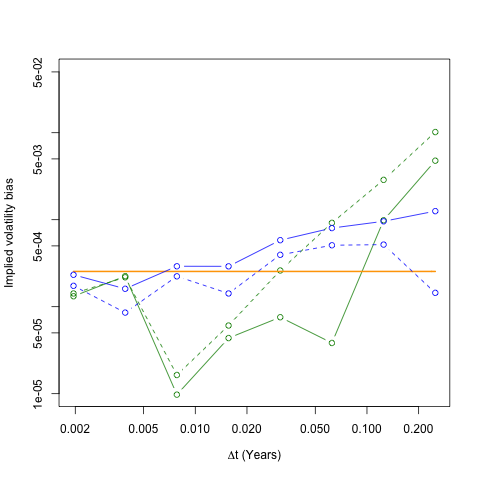

In [26]:
tmp <- resFAndersen.BCC
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="green4",lty=2)
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)
tmp <- resNV.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="blue",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
points(1/tmp$Steps,abs(tmp$biasRichardson),type="b",col="blue",lty=2)

Figure 8: Euler with full truncation and Andersen $x$-discretization in green; Ninomiya-Victoir in blue; dashed lines are with Richardson extrapolation ($T=1$, $K=1.2$)


* Let's leave the fixing of NV for future research...

###Summary convergence plot

Now we put results using all schemes so far on the same plot.

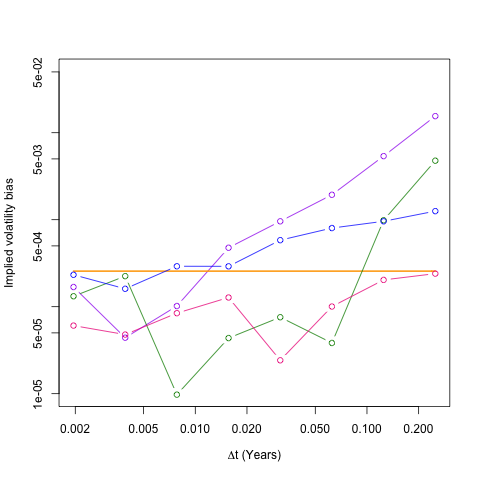

In [27]:
tmp <- resF.BCC
sdThreshold <- mean(tmp$twoSd)
plot(1/tmp$Steps,abs(tmp$bias),type="b",log="xy",col="purple",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))
curve(sdThreshold+x*0,from=1/512, to=1/4,add=T,col="orange",lwd=2)

tmp <- resFAndersen.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="green4",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))

tmp <- resAlfonsi.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="deeppink2",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))

tmp <- resNV.BCC
lines(1/tmp$Steps,abs(tmp$bias),type="b",col="blue",ylab="Implied volatility bias",ylim=c(0.00001,0.05),xlab=expression(paste(Delta,t, " (Years)")))


Figure 9: Euler with full truncation in purple; with Andersen $x$-discretization in green; Alfonsi in pink; Ninomiya-Victoir in blue; 

* Let's stick with Alfonsi with full truncation!

###More complicated models

* It is typically thought that the Ninomiya-Victoir scheme gives rise to closed form ODE solutions for each time step only in lucky special cases such as Heston.

    * The reason is that the $V_0$ ODE is typically not soluble in closed-form.


* In [Bayer, Gatheral and Karlsmark]<sup id="cite_ref-BGK" class="reference"><a href="#cite_note-BGK"><span>[</span>3<span>]</span></a></sup>, we show that we may further split the $V_0$ operator, writing *e.g.* $V_0=V_{0,1}+V_{0,2}$ achieving closed-form time steps whilst maintaining $O(\Delta^2)$ accuracy.

    * In particular, we may efficiently simulate much more complicated models such as DMR.


* The form of the $k$th time step is:
    
    \begin{eqnarray}
    &&X\left((k+1)\,\Delta,x\right)\\
    &=&\left\{
    \begin{array}{ll}
    e^{\frac 12\Delta\, V_{0,1}}\,e^{\frac 12\Delta\, V_{0,2}}\,e^{Z_k^1\, V_1}\,e^{Z_k^2\, V_2}\,e^{Z_k^3\, V_3}\, e^{\frac 12\Delta\, V_{0,2}}\,e^{\frac 12\Delta\, V_{0,1}} X(k\,\Delta,x)&  \text{ if } \Lambda_k=-1  \\
    e^{\frac 12\Delta\, V_{0,1}}\,e^{\frac 12\Delta\, V_{0,2}}\,e^{Z_k^3\, V_3}\,e^{Z_k^2\, V_2}\,e^{Z_k^1\, V_1}\, e^{\frac 12\Delta\, V_{0,2}}\,e^{\frac 12\Delta\, V_{0,1}} X(k\,\Delta,x)&  \text{ if } \Lambda_k=+1  \\
    \end{array}
    \right.
    \end{eqnarray}

    where the $Z_k^i \sim N(0,\Delta)$ are independent.

###A remark on mathematical innovation driven by applications


* This is the first example in our lecture series of financial applications spurring pure mathematical innovation.

    * Specifically, rough paths theory and the Ninomiya-Victoir scheme.
    
<!--
* The Heston model serves as a useful test for the convergence of new simulation schemes.
-->

###Quasi-Monte Carlo


* Quasi-Monte Carlo uses low discrepancy sequences instead of random numbers.

    * Low discrepancy sequences distribute points evenly without placing them at regular grid points.
        
    
* Monte Carlo converges at rate $\mathcal{O}(1/\sqrt{N})$.


* Under the right conditions, Quasi-Monte Carlo converges at a rate approximately $\mathcal{O}(1/N)$.

###Quasi-Monte Carlo in R

In R, quasi-random numbers are just as easy to use as pseudo-random numbers:

In [28]:
library(randtoolbox) # This library has the QMC functionality

print(zmc <- rnorm(10)) # generates 10 normal pseudo-random numbers
print(zqmc <- sobol(n=10,dim=4,scram=3,seed=4711,norm=T)) # generates a 10 x 4 matrix of normal quasi-random numbers

Loading required package: rngWELL
This is randtoolbox. For overview, type 'help("randtoolbox")'.


 [1]  0.72274574 -0.24159542  1.19935447  0.42876057 -0.80677492  0.01726428
 [7]  0.34841920 -0.64014501  2.62656307  0.31987264
            [,1]        [,2]         [,3]        [,4]
 [1,]  0.7548562 -0.71665875 -1.401770664  0.96622222
 [2,]  0.5374604  0.11132384 -0.430229472 -0.73046181
 [3,] -1.2788761 -0.39428055  1.898200769  0.25907372
 [4,]  1.3731449  0.80630613  0.690388634 -1.63730037
 [5,] -0.5832688 -1.28067627 -0.190000436  0.45199060
 [6,] -0.8080373  0.47115094 -0.927083855 -0.64501117
 [7,]  0.2400209 -0.01967126  0.006865142  1.22540384
 [8,] -3.2466265  1.12617028 -0.154345105  0.83815856
 [9,]  0.4643494 -1.63068840  1.107803702 -0.18525837
[10,]  1.1460069  0.61327748  0.280623630  0.03821902


###Quasi-Monte Carlo code

In [29]:
HestonQMC <- function(params){
    
    is.even <- function(j){as.logical((j+1) %% 2)}
    
    res <- function(S0, T, AK, N, m, evolve,exactVols=NULL)
    {
  
    lambda <<- params$lambda
    rho <<- params$rho
    eta <<- params$eta
    vbar <<- params$vbar
    v0 <<- params$v
  
    n <- m*2 #n is number of timesteps = 2*m so we can use Romberg extrapolation
    sqrt2 <- sqrt(2)
    rho2m1 <<- sqrt(1-rho*rho)
    vbarp <<- vbar - eta^2/(4*lambda)
    
    negCount <- 0
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); v <- rep(1,N)*v0
    xm <- x; vm <- v
    W1m <- rep(0,N); W2m <- rep(0,N)
    
    # Generation of quasi random numbers now takes place outside the timestep loop
    Z <- sobol(n=N,dim=n,scram=3,seed=4711,norm=T)
      Zperp <- sobol(n=N,dim=n,scram=3,seed=17,norm=T)
      
    # Loop for bias computation (N small, n big)
    for (i in 1:n)
    {
        # Two sets of correlated normal random vars.
        
        W1 <- Z[,i] #Take ith column of pre-generated quasi-rvs
        W2 <- Zperp[,i]
        W1 <- W1 - mean(W1); W1 <- W1/sd(W1)
        W2 <- W2 - mean(W2); W2 <- W2/sd(W2)
        # Now W1 and W2 are forced to have mean=0 and sd=1
        
        W2p <- W2 - cor(W1,W2)*W1 # Eliminate actual correlation
        W2p <- W2p - mean(W2p); W2 <- W2p/sd(W2p) 
        # Now W1 and W2 have mean=0, sd=1 and correlation=0
        
        L <- rbinom(N, size=1, prob=1/2) # Bernoulli rv for NV step
    
        # Add code for subgrid
        W1m <- W1m + W1/sqrt2; W2m <- W2m + W2/sqrt2 # N(0,1) rv's for subgrid
       
        if (is.even(i)) {
            resm <- evolve(vm,xm,T/m,W1m,W2m,L)
            xm <- resm[,1]
            vm <- resm[,2]
            W1m <- rep(0,N); W2m <- rep(0,N);
        }
    
        res <- evolve(v,x,T/n,W1,W2,L)
        x <- res[,1]
        v <- res[,2]
        
  }

    S <- S0*exp(x)
    Sm <- S0*exp(xm)

    # Now we have three vectors of final stock prices
    M <- length(AK);
    AV <- numeric(M); AVdev <- numeric(M);
    BSV <- numeric(M); BSVH <- numeric(M); BSVL <- numeric(M);
    iv2SD <- numeric(M); bias <- numeric(M);
    AVm <- numeric(M); AVmdev <- numeric(M);
    BSVm <- numeric(M); BSVHm <- numeric(M); BSVLm <- numeric(M);
    iv2SDm <- numeric(M);
    AV1 <- numeric(M); AV1dev <- numeric(M);
    BSV1 <- numeric(M); BSVH1 <- numeric(M); BSVL1 <- numeric(M);
    iv2SDrom <- numeric(M);biasRom <- numeric(M);
  
  # Evaluate mean call value for each path
  for (i in 1:M)
  {
    # 2*m timesteps
    K <- AK[i];
    V <- (S>K)*(S - K); # Boundary condition for European call
    AV[i] <- mean(V);
    AVdev[i] <- sqrt(var(V)/length(V));
    BSV[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i]);
    BSVL[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] - AVdev[i]);
    BSVH[i] <- BSImpliedVolCall(S0, K, T, 0, AV[i] + AVdev[i]);
    iv2SD[i] <- (BSVH[i]-BSVL[i]);
    
    # m timesteps
    Vm <- (Sm>K)*(Sm - K); # Boundary condition for European call
    AVm[i] <- mean(Vm);
    AVmdev[i] <- sd(Vm) / sqrt(N);
    BSVm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i]);
    BSVLm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] - AVmdev[i]);
    BSVHm[i] <- BSImpliedVolCall(S0, K, T, 0, AVm[i] + AVmdev[i]);
    iv2SDm[i] <- (BSVH[i]-BSVL[i]);
    
    # Richardson extrapolation estimates 
    V1 <- 2*V - Vm
    AV1[i] <- mean(V1)
    AV1dev[i] <- sd(V1) / sqrt(N)
    BSV1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i])
    BSVL1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] - AV1dev[i])
    BSVH1[i] <- BSImpliedVolCall(S0, K, T, 0, AV1[i] + AV1dev[i])
    iv2SDrom[i] <- (BSVH1[i]-BSVL1[i])
    
    if(!is.null(exactVols)) {bias <- BSV-exactVols}
    if(!is.null(exactVols)) {biasRom <- BSV1-exactVols}
  }
  
  data.out <- data.frame(AK,rep(N,M),rep(2*m,M),BSV,bias,iv2SD,BSVm,BSV1,biasRom,iv2SDrom)
  names(data.out) <- c("Strikes","Paths","Steps","ivol","bias","2sd","ivolm", "ivolRichardson", "biasRichardson",
                       "2sdRichardson")
  return(data.out)
  
}
return(res)
}


Example of HestonQMC call:

In [30]:
HestonQMC(paramsBCC)(S0=1, T=1, AK=strikes, N=100000, m=4, evolve=evolveNV, exactVols=exactHestonVolsBCC) 

  Strikes Paths Steps      ivol          bias         2sd     ivolm
1     0.8 1e+05     8 0.2297438  0.0007480732 0.004361094 0.2304267
2     1.0 1e+05     8 0.1815129 -0.0002152532 0.001552826 0.1812508
3     1.2 1e+05     8 0.1511792 -0.0008685494 0.001133325 0.1507949
  ivolRichardson biasRichardson 2sdRichardson
1      0.2290591   6.333226e-05   0.004688000
2      0.1817749   4.681220e-05   0.001736276
3      0.1515622  -4.856040e-04   0.001367169

###Convergence of QMC

* We use the Alfonsi-Andersen discretization with 16 timesteps.

    * The bias was well within our $0.10$ vol point tolerance.
    

* We compute the convergence of Monte Carlo and Quasi Monte Carlo as a a function of $N$.

###Convergence of QMC and MC with BCC parameters

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/10/QMCconvergence.png" align = "left" width=750></h3> 

Figure 10: Implied vols for a call ($T=1$, $K=1.2$); MC in blue; QMC in red; $0.1$ vol point threshold in orange.

###Convergence of QMC and MC with BCC parameters: Zoomed

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/10/QMCconvergenceZoom.png" align = "left" width=750></h3> 

Figure 11: Implied vols for a call ($T=1$, $K=1.2$); MC in blue; QMC in red; $0.1$ vol point threshold in orange.

###QMC vs MC

* Mostly, QMC converges faster than MC.


* However,

    * We can't easily quantify errors as we can with Monte Carlo.

    * QMC may have problems in higher dimensions:

        * The rule-of-thumb is to use no more than 40 dimensions.
        
        * See the randtoolbox vignette [http://cran.r-project.org/web/packages/randtoolbox/randtoolbox.pdf](http://cran.r-project.org/web/packages/randtoolbox/randtoolbox.pdf) for details of how performance has been improved in R by scrambling. 

###QMC problems in higher dimensions

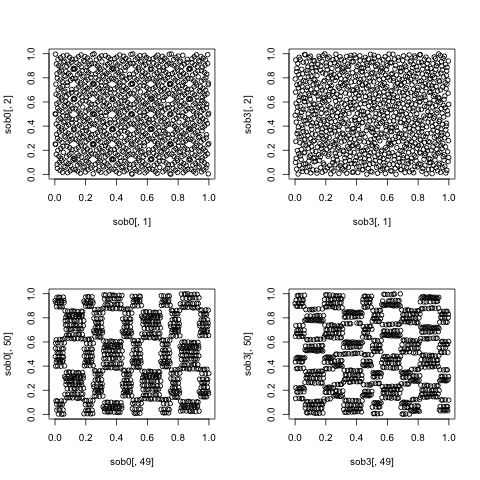

In [31]:
# Sobol in higher dimensions
par(mfrow=c(2,2))
sob0 <- sobol(n=1000,dim=500,scram=0)
sob3 <- sobol(n=1000,dim=500,scram=3)

plot(sob0[,1],sob0[,2])
plot(sob3[,1],sob3[,2])

plot(sob0[,49],sob0[,50])
plot(sob3[,49],sob3[,50])

par(mfrow=c(1,1))

Figure 12: Correlations between dimensions of low discrepancy sequences (Sobol)

###No such problem with MC

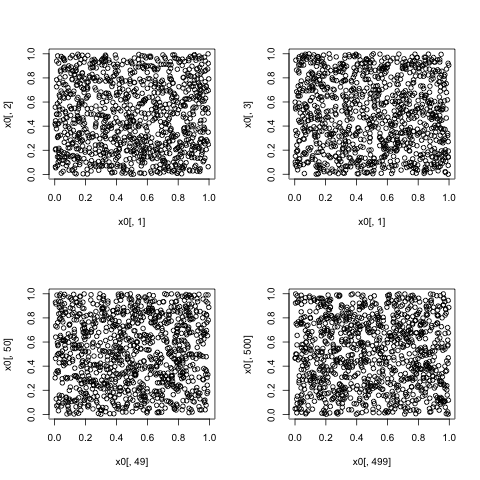

In [32]:
# Compare with rnorm
par(mfrow=c(2,2))
x0 <- array(runif(n=500000),dim=c(1000,500));

plot(x0[,1],x0[,2])
plot(x0[,1],x0[,3])

plot(x0[,49],x0[,50])
plot(x0[,499],x0[,500])

par(mfrow=c(1,1))

Figure 13: Correlations between pseudo-random numbers

###Applications


* Now we have an efficient simulation scheme that we can use to compute various quantities of interest:

    * Alfonsi with full truncation, 16 timesteps; QMC with 25,000 paths.
    
    * We may want to increase the number of timesteps for path-dependent options.


* To finish the lecture, let's draw some pictures using data generated from MC and QMC.

###The 1-year implied volatility smile: BCC parameters.

<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/10/VolSmile.png" align = "left" width=600></h3> 

Figure 14: Exact implied vols in blue; MC in red; QMC in green; There's almost no difference when we have 1 million paths!

###1-year local and implied variance: BCC parameters


<h3><img src="http://mfe.baruch.cuny.edu/wp-content/uploads/2014/10/LocalVolImpliedVol.png" align = "left" width=600></h3> 

Figure 15: Local variance (dark green) obtained by binning final variance (with error bars); implied variance (red) is superimposed (1 million paths again)

###The Heston volatility surface again

First, setup the plot generated from the analytical solution (Lecture 3)

In [33]:
k <- seq(-.5,.5,0.05) # Vector of log-strikes
t <- (1:36)/18 # Vector of times
vol1 <- function(k,t){impvolHeston(paramsBCC)(k,t)}
vol2 <- function(k,t){sapply(k,function(k){vol1(k,t)})}
vol <- function(k,t){sapply(t,function(t){vol2(k,t)})}

system.time(zvol <- vol(k,t))

   user  system elapsed 
  1.019   0.029   1.051 

Now change the Monte Carlo code to output a matrix of volatilities:

In [34]:
HestonSurfaceMC <- function(params){
  
  res <- function(S0, T, Ak, N, m, evolve)
  {
    
    M <- length(Ak);
    BSV <- array(dim=c(m,M));
    AV <- numeric(M); 
    
    lambda <<- params$lambda;
    rho <<- params$rho;
    eta <<- params$eta;
    vbar <<- params$vbar;
    v0 <<- params$v;
    
    n <- m; #n is number of timesteps; No Romberg this time
    sqrt2 <- sqrt(2);
    rho2m1 <<- sqrt(1-rho*rho);
    vbarp <<- vbar - eta^2/(4*lambda);
    
    # We use a vertical array, one element per M.C. path
    x <- rep(0,N); v <- rep(1,N)*v0;
    
    # Generation of quasi random numbers now takes place outside the timestep loop
    Z <- sobol(n=N,dim=n,scram=3,seed=4711,norm=T);
    Zperp <- sobol(n=N,dim=n,scram=3,seed=17,norm=T);
    
    # Loop over timesteps
    for (i in 1:n)
    {
      # Two sets of correlated normal random vars.
      
      W1 <- Z[,i]; #Take ith column of pre-generated quasi-rvs
      W2 <- Zperp[,i];
      W1 <- W1 - mean(W1); W1 <- W1/sd(W1);
      W2 <- W2 - mean(W2); W2 <- W2/sd(W2);
      # Now W1 and W2 are forced to have mean=0 and sd=1
      
      W2p <- W2 - cor(W1,W2)*W1; # Eliminate actual correlation
      W2p <- W2p - mean(W2p); W2 <- W2p/sd(W2p); 
      # Now W1 and W2 have mean=0, sd=1 and correlation=0
      
      res <- evolve(v,x,T/n,W1,W2,L);
      x <- res[,1];
      v <- res[,2];
      
      S <- S0*exp(x); # Vector of stock prices at time t=T*i/m;
      
      # Evaluate mean call value for each path
      for (j in 1:M)
      {
        k <- Ak[j];
        K <- exp(k);
        V <- (S>K)*(S - K); # Boundary condition for European call
        AV[j] <- mean(V);
      }
      
      BSV[i,] <- BSImpliedVolCall(S0, exp(Ak), T*i/m, 0, AV);   # Compute ith row of output matrix
    }
    
    res <- list(BSV=BSV,logStrikes=Ak,expiries=seq(0,T,T/m));
  }
  return(res);
}

Run this new vol surface code with 50 timesteps and 50,000 paths:

In [35]:
system.time(volSurface <- HestonSurfaceMC(paramsBCC)(S0=1, T=2, Ak=k, N=50000, m=36, evolve=evolveAlfonsiF))

   user  system elapsed 
  0.827   0.460   1.290 

Note that the above code is as fast as calling the code with the quasi-closed form solution many times!

###Plot the two surfaces together

Warning message:
In persp.default(k, t, z, col = color[facetcol], phi = 30, theta = 30, : surface extends beyond the boxWarning message:
In persp.default(k, t, z, col = color[facetcol], phi = 30, theta = 30, : surface extends beyond the box

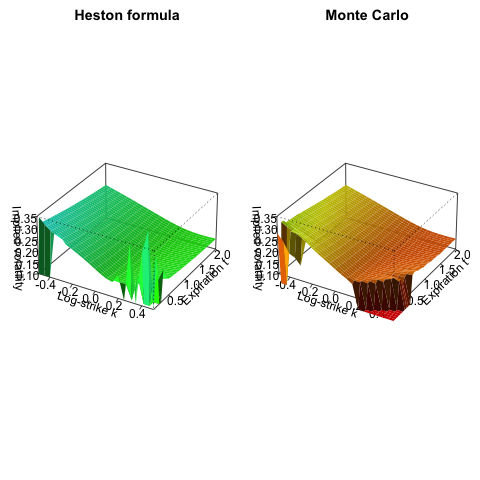

In [36]:
par(mfrow=c(1,2),mex=0.5)
par(oma=c(0,0,0,0))

# First the analytical formula: 
z <- (zvol>.10)*zvol+(zvol <= 0.1)*.1

# Add colors
nbcol <- 100
color <- rainbow(nbcol,start=.3,end=.5)
nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol)

# Generate 3D plot of analytical solution
persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
      r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
      shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",main="Heston formula",zlim=c(.1,.35));


# Next the Monte Carlo result

z2 <- t(volSurface$BSV)
z <- (z2>0.05)*z2+(z2<=.1)*.05

# Add colors
nbcol <- 100
color <- rainbow(nbcol,start=.0,end=.2)
nrz <- nrow(z)
ncz <- ncol(z)
# Compute the z-value at the facet centres
zfacet <- z[-1, -1] + z[-1, -ncz] + z[-nrz, -1] + z[-nrz, -ncz]
# Recode facet z-values into color indices
facetcol <- cut(zfacet, nbcol)

# Generate 3D plot of MC solution

persp(k, t, z, col=color[facetcol], phi=30, theta=30, 
      r=1/sqrt(3)*20,d=5,expand=.5,ltheta=-135,lphi=20,ticktype="detailed",
      shade=.5,border=NA,xlab="Log-strike k",ylab="Expiration t",zlab="Implied volatility",
      main="Monte Carlo",zlim=c(.1,.35))

par(mfrow=c(1,1),mex=1)

Figure 16: 3D plots of the Heston volatility surface with BCC parameters; Closed-form Heston formula on the left, Monte Carlo on the right.

###Summary

* Financial applications are now inspiring (great) mathematicians to find new results.


* These results are already being put to practical use, generating more efficient algorithms.


* Because there is a quasi-closed form formula and because the underlying process is not easy to simulate, the Heston model makes a great test-bed for algorithms.




* Finally, we have a practical (Quasi) Monte Carlo algorithm (Alfonsi with full truncation and Andersen x-discretization) that can be used in later lectures.

## References

<br />

<div class="reflist" style="list-style-type: decimal;">

<ol>
  
  <!--   <li id="cite_note-Alfonsi:2005"><span class="mw-cite-backlink"><b><a href="#cite_ref-Alfonsi:2005">^</a></b></span>  Aurélien Alfonsi, On the discretization schemes for the CIR (and Bessel squared) processes., <span>*Monte Carlo Methods and Applications*</span> <span>**11**(4)</span>, 355–384 (2005).</li>  -->
  
  <li id="cite_note-Alfonsi:2010"><span class="mw-cite-backlink"><b><a href="#cite_ref-Alfonsi:2010">^</a></b></span>   Aurélien Alfonsi, High order discretization schemes for the CIR process: application to affine term structure and Heston models, <span>*Mathematics of Computation*</span> <span>**79**(269)</span>, 209–237 (2010).</li>
  
    <li id="cite_note-Andersen"><span class="mw-cite-backlink"><b><a href="#cite_ref-Andersen">^</a></b></span>   Andersen, Leif B G, Simple and efficient simulation of the Heston stochastic volatility model, <span>*Journal of Computational Finance*</span> <span>**11**(3)</span>, 1–42 (2008).</li>
  
<!--   <li id="cite_note-AvellanedaWMC"><span class="mw-cite-backlink"><b><a href="#cite_ref-AvellanedaWMC">^</a></b></span>   Marco Avellaneda, Robert Buff, Craig Friedman, Nicolas Grandechamp, Lukasz Kruk, and Joshua Newman, Weighted Monte Carlo: a new technique for calibrating asset-pricing models,  <span>*International Journal of Theoretical and Applied Finance*</span> <span>**4**(1)</span>, 91–119 (2001).</li> 
  
   <li id="cite_note-BroadieKaya"><span class="mw-cite-backlink"><b><a href="#cite_ref-BroadieKaya">^</a></b></span>   Broadie, Mark and Özgür Kaya, Exact simulation of stochastic volatility and other affine jump diffusion processes, <span>*Operations Research*</span> <span>**54**(2)</span>, 217–231 (2006).</li> 

  <li id="cite_note-FrizEtAl"><span class="mw-cite-backlink"><b><a href="#cite_ref-FrizEtAl">^</a></b></span>   Christian Bayer, Peter Friz, and Ronnie Loeffen, Semi-closed form cubature and applications to financial diffusion models, <span>*Quantitative Finance*</span> <span>**13**(5)</span>, 769–782 (2013).</li> -->
  
  <li id="cite_note-BGK"><span class="mw-cite-backlink"><b><a href="#cite_ref-BGK">^</a></b></span>   Christian Bayer, Jim Gatheral, and Morten Karlsmark, 
Fast Ninomiya-Victoir calibration of the double-mean-reverting model, <span>*Quantitative Finance*</span> <span>**13**(11)</span>, 1813–1829 (2013).</li>

<!--  <li id="cite_note-Gatheral"><span class="mw-cite-backlink"><b><a href="#cite_ref-Gatheral">^</a></b></span>   Jim Gatheral,  <span>*The Volatility Surface: A Practitioner's Guide*</span>, John Wiley and Sons, Hoboken, NJ (2006).</li>

  <li id="cite_note-Glasserman"><span class="mw-cite-backlink"><b><a href="#cite_ref-Glasserman">^</a></b></span>  Paul Glasserman,  <span>*Monte Carlo Methods in Financial Engineering*</span>, Springer-Verlag, Heidelberg (2004).</li>

  <li id="cite_note-KloedenPlaten"><span class="mw-cite-backlink"><b><a href="#cite_ref-KloedenPlaten">^</a></b></span>  Peter E. Kloeden and Eckhard Platen, <span>*Numerical Solution of Stochastic Differential Equations*</span>, Springer-Verlag, Heidelberg (1992).</li> 

  <li id="cite_note-LKV"><span class="mw-cite-backlink"><b><a href="#cite_ref-LKV">^</a></b></span>  Roger Lord, Remmert Koekkoek and Dick Van Dijk, A Comparison of biased simulation schemes for stochastic volatility models., <span>*Quantitative Finance*</span> <span>**10**(2)</span>, 177–194 (2010).</li>  -->

  <li id="cite_note-NinomiyaVictoir"><span class="mw-cite-backlink"><b><a href="#cite_ref-NinomiyaVictoir">^</a></b></span>  Syoiti Ninomiya and Nicolas Victoir, Weak approximation of stochastic differential equations and application to derivative pricing, <span>*Applied Mathematical Finance*</span> <span>**15**(2)</span>, 107–121(2008).</li>

  <!-- <li id="cite_note-TavellaRandall"><span class="mw-cite-backlink"><b><a href="#cite_ref-TavellaRandall">^</a></b></span>  Domingo Tavella and Curt Randall <span>*Pricing Financial Instruments: The Finite Difference Method*</span>,  John Wiley and Sons, Hoboken, NJ (2000).</li>  -->
  
</ol>